# Проект классификации текстов, сгенерированных ChatGPT

Задача выявления правильно сгенерированных ChatGPT текстов может быть полезна для автоматического отсеивания неподходящего под условия материала, чтобы приходилось меньше текстов просматривать вручную.

В данном случае анализируется датасет сгенерированных ChatGPT диалогов. ChatGPT должна была сгенерировать пары реплик, где вторая реплика обязательно должна содержать благодарность (и только благодарность) и помечена тегом 'thanking'. Однако ChatGPT не совсем хорошо справилась с задачей, поэтому в датасет попали диалоги, где вторая реплика содержит либо какой-то ответ с благодарностью, либо ответ на извинение, либо вообще не содержит никакого указания на благодарность.

Задача - создать классификатор с наилучшим качеством, способный определять, что ChatGPT сгенерировала подходящую или не подходящую под условие пару реплик.


## Подготовка

In [1]:
# загрузка необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
!pip install catboost
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# загрузка датасета
df = pd.read_csv('/content/df_thanking - df_thanking.csv')

df.head()

,stimulus,reaction_2,tag,tag_true
0,here are the documents you asked for,thank you i appreciate it,thanking;,1
1,could you please pass me the salt,sure here you go,thanking;,0
2,i'm sorry for being late,no worries thanks for letting me know,thanking;,0
3,that dress looks really nice on you,thanks so much that's really sweet of you to say,thanking;,1
4,can you believe how beautiful this view is,thanks for pointing that out it really is brea...,thanking;,0


Все реплики помечены ChatGPT одним и тем же тегом. Но колонка 'tag_true' содержит результаты ручной проверки, где указано, правильно поставлен тег или нет. Так можно увидеть, что ответные реплики под индексами 0 и 3 являются "чистой" благодарностью, реплика под индексом 1 вообще не содержит благодарности, а реплики под индексами 2 и 4 должны помечаться не только тегом 'thanking', но и тегами 'apology response' или 'answer' соответственно.

Столбец "tag" нам дальше не понадобится, поэтому мы его удалим.

In [3]:
# корректировка состава столбцов
df = df[['stimulus', 'reaction_2', 'tag_true']]

# функция для изучения данных датафрейма
def open_info(data):
    # вывод 5 строк данных
    print('*******************************************************')
    print('Представление датафрейма')
    display(data.head(3))
    print('*******************************************************')
    # вывод информации о датафрейме
    print('Общая информация о датафрейме')
    print('')
    print(data.info())
    print('*******************************************************')
    # проверка на наличие пропусков
    print('Пропуски:', data.isna().sum().sum())
    print('*******************************************************')
    print('Наличие пропусков по столбцам')
    print(data.isna().any())
    print('*******************************************************')
    # проверка на наличие дубликатов
    print('Дубликаты:', data.duplicated().sum())

In [4]:
open_info(df)

*******************************************************
Представление датафрейма


,stimulus,reaction_2,tag_true
0,here are the documents you asked for,thank you i appreciate it,1
1,could you please pass me the salt,sure here you go,0
2,i'm sorry for being late,no worries thanks for letting me know,0


*******************************************************
Общая информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   stimulus    354 non-null    object
 1   reaction_2  354 non-null    object
 2   tag_true    354 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 8.4+ KB
None
*******************************************************
Пропуски: 0
*******************************************************
Наличие пропусков по столбцам
stimulus      False
reaction_2    False
tag_true      False
dtype: bool
*******************************************************
Дубликаты: 3


Датасет состоит из 354 пар высказываний. В датасете нет пропусков, но есть три дубликата, от которых следует избавиться.

In [5]:
# удаление дубликатов
df = df.drop_duplicates()

# проверка
print('Дубликаты:', df.duplicated().sum())

Дубликаты: 0


1    203
0    148
Name: tag_true, dtype: int64

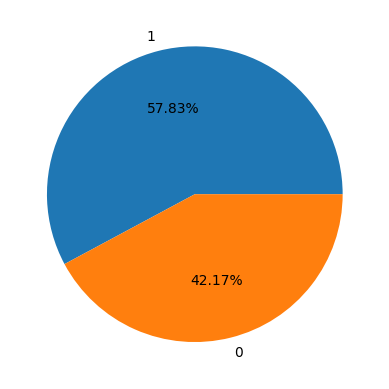

In [6]:
# Подсчет количества уникальных значений в столбце
value_counts = df['tag_true'].value_counts()
display(value_counts)

# Создание круговой диаграммы
plt.pie(value_counts, labels=value_counts.index, autopct='%1.2f%%')

# Отображение диаграммы
plt.show()

Как видим, классы не сбалансированы. 206 пар высказываний соответствуют условию и содержат только благодарность и 148 пар не соответствуют. При обучении моделей такой дисбаланс классов следует попытаться учесть, хотя он не столько большой.

## Предобработка данных

Прежде чем извлечь признаки из текста, нужно его упростить. Для этого необходимо сделать лемматизацию, очищение текста и токенизацию.

In [7]:
# функция, чтобы вернуть слово к начальной форме
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# функция лемматизации
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    lemm_list = nltk.word_tokenize(text)
    lemm_text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lemm_list])
    return lemm_text

# функция очищения текста
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text)
    clear_text = clear_text.lower().split()
    return ' '.join(clear_text)


In [8]:
# токенизация первого столбца
df['lemm_stimulus'] = df['stimulus'].apply(lambda text: lemmatize(clear_text(text)))

# проверка
display(df.loc[0, 'stimulus'])
df.loc[0, 'lemm_stimulus']

'here are the documents you asked for'

'here be the document you ask for'

In [9]:
# токенизация второго столбца
df['lemm_reaction'] = df['reaction_2'].apply(lambda text: lemmatize(clear_text(text)))

# проверка
display(df.loc[2, 'reaction_2'])
df.loc[2, 'lemm_reaction']

'no worries thanks for letting me know'

'no worry thanks for let me know'

In [10]:
# переопределим датасет, оставив только важное
df = df[['lemm_stimulus', 'lemm_reaction', 'tag_true']]
# проверка
df.head(3)

,lemm_stimulus,lemm_reaction,tag_true
0,here be the document you ask for,thank you i appreciate it,1
1,could you please pas me the salt,sure here you go,0
2,i m sorry for be late,no worry thanks for let me know,0


Векторизацию столбцов сделаем двумя способами и посмотрим, как это отразится на результатах моделей.

### TF-IDF

In [11]:
# получение TF-IDF для корпуса текста
tf_idf = TfidfVectorizer()

tfidf = tf_idf.fit_transform(df['lemm_stimulus'] + ' ' + df['lemm_reaction'])

# размеры матриц
tfidf.shape

(351, 587)

### Doc2Vec

In [12]:
corpus = df['lemm_stimulus'] + ' ' + df['lemm_reaction']

df["text"] = corpus.apply(lambda x: x.lower().split())

input_text = list(df.text.values)

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(input_text)]

# модель
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# создадим список с векторами для каждого текста
vectors = []
for x in documents:
    vec = list(model.dv[x.tags][0])
    vectors.append(vec)

# получим датафрейм, где все компоненты векторов в отдельных столбцах
split_df = pd.DataFrame(vectors,
                        columns=['v1', 'v2', 'v3', 'v4', 'v5'])

split_df

<ipython-input-12-b7b4d7c77841>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text"] = corpus.apply(lambda x: x.lower().split())


,v1,v2,v3,v4,v5
0,-0.111681,0.002048,-0.153619,0.044512,0.067797
1,-0.005597,-0.021641,-0.042800,-0.382014,0.031102
2,0.050634,0.240664,-0.033800,-0.214469,-0.068981
3,-0.194487,0.339171,0.300947,-0.501558,-0.074783
4,-0.090239,0.366254,0.008191,-0.270365,0.108573
...,...,...,...,...,...
346,-0.146563,0.168657,0.231767,0.065564,0.193526
347,-0.171270,0.086947,0.047687,0.005475,0.078668
348,0.125205,0.204592,-0.052787,-0.222455,-0.071779
349,0.139854,0.236199,0.268766,-0.307642,-0.153743


Далее подготовим признаки для обучения моделей

In [13]:
# целевой признак
y = df['tag_true'].values

In [14]:
# признаки (TF-IDF)
split_df_train, split_df_test, y_train, y_test = train_test_split(split_df, y, test_size=0.3, random_state=42)

print(split_df_train.shape)
print(split_df_test.shape)
print(y_train.shape)
print(y_test.shape)

(245, 5)
(106, 5)
(245,)
(106,)


In [15]:
# признаки (Doc2Vec)
tfidf_train, tfidf_test, y_train, y_test = train_test_split(tfidf, y, test_size=0.3, random_state=42)

print(tfidf_train.shape)
print(tfidf_test.shape)
print(y_train.shape)
print(y_test.shape)

(245, 587)
(106, 587)
(245,)
(106,)


Таким образом, мы подготовили данные для обучения модели. Преобразовали высказывания в векторный вид, необходимый для обучения моделей, двумя способами.


## Обучение

Обучим несколько моделей и оценим полученные результаты. Модели для обучения: LogisticRegression, RandomForestClassifier и CatBoostClassifier


In [16]:
def evaluate_model(model, X_test, y_test, cmap):
    # Предсказание классов и вероятностей
    predicted = model.predict(X_test)
    probabilities = model.predict_proba(X_test)
    probabilities_one = probabilities[:, 1]

    # Рассчет метрик
    result_f1 = f1_score(y_test, predicted)
    result_auc_roc = roc_auc_score(y_test, probabilities_one)

    # Вывод результатов
    print("F1-мера:", "{:.2f}".format(result_f1))
    print('AUC-ROC:', "{:.2f}".format(result_auc_roc))

    # Создание DataFrame для хранения результатов
    metrics_df = pd.DataFrame({
        'Model': [model.__class__.__name__],
        'F1 Score': [result_f1],
        'AUC-ROC': [result_auc_roc]
    })

    # Рассчитать матрицу ошибок
    cm = confusion_matrix(y_test, predicted)

    # Создание фигуры с меньшими размерами
    fig, ax = plt.subplots(figsize=(6, 4), dpi=80)

    # Постройте тепловую карту матрицы ошибок
    sns.heatmap(cm, annot=True, cmap=cmap, ax=ax)

    # Настройка меток осей
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Установка заголовка
    ax.set_title('Тепловая карта матрицы ошибок')

    # Показать график
    plt.show()


### Модель LogisticRegression

#### Модель LogisticRegression обученная на данных, векторизованных TF-IDF

F1-мера: 0.89
AUC-ROC: 0.95


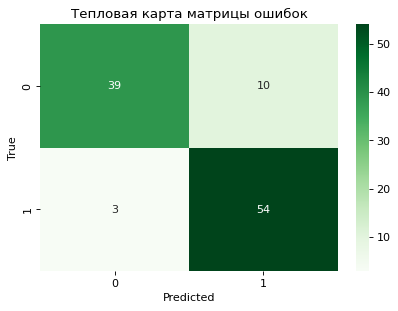

In [17]:
model_LR_tf = LogisticRegression(random_state=12345)
model_LR_tf.fit(tfidf_train, y_train)

evaluate_model(model_LR_tf, tfidf_test, y_test, 'Greens')

#### Модель LogisticRegression (с балансированными классами) на данных, векторизованных TF-IDF

F1-мера: 0.92
AUC-ROC: 0.95


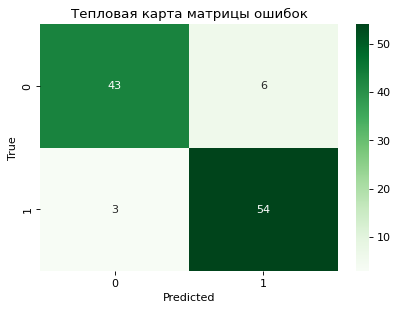

In [18]:
model_LR_tf_w = LogisticRegression(random_state=12345, class_weight='balanced')
model_LR_tf_w.fit(tfidf_train, y_train)

evaluate_model(model_LR_tf_w, tfidf_test, y_test, 'Greens')

#### Модель LogisticRegression на данных векторизованных Doc2Vec

F1-мера: 0.70
AUC-ROC: 0.55


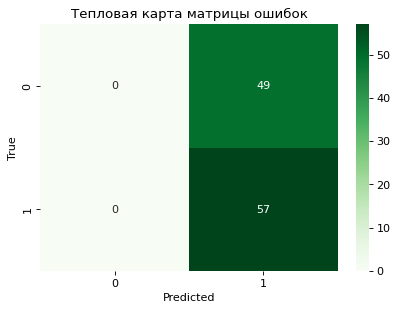

In [19]:
model_LR_vec = LogisticRegression(random_state=12345)
model_LR_vec.fit(split_df_train, y_train)

evaluate_model(model_LR_vec, split_df_test, y_test, 'Greens')

#### Модель LogisticRegression (с балансированными классами) на данных векторизованных Doc2Vec

F1-мера: 0.56
AUC-ROC: 0.55


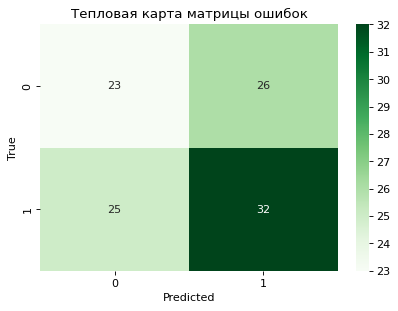

In [20]:
model_LR_vec_w = LogisticRegression(random_state=12345, class_weight='balanced')
model_LR_vec_w.fit(split_df_train, y_train)

evaluate_model(model_LR_vec_w, split_df_test, y_test, 'Greens')

По метрике F1 лучшая модель - модель LogisticRegression (с балансированными классами) на данных, векторизованных TF-IDF. F1 = 0.92. По метрике AUC-ROC лучшая модель - модель LogisticRegression на данных, векторизованных TF-IDF (как сбалансированная, так и несбалансированная). AUC = 0.95.

### Модель RandomForestClassifier

In [21]:
# функция для подбора параметров
def find_best_model(X_train, y_train, X_test, y_test):
    best_model = None
    best_result = 0
    best_depth = 0
    best_est = 0

    for depth in range(1, 20):
        for est in range(2, 30):
            model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
            model.fit(X_train, y_train)
            predicted = model.predict(X_test)
            result = f1_score(y_test, predicted)

            if result > best_result:
                best_model = model
                best_result = result
                best_depth = depth
                best_est = est

    return best_model

In [22]:
# модель на данных, векторизованных TF-IDF
best_model_forest_tf = find_best_model(tfidf_train, y_train, tfidf_test, y_test)
# модель на данных, векторизованных Doc2Vec
best_model_forest_vec = find_best_model(split_df_train, y_train, split_df_test, y_test)

#### Модель RandomForestClassifier на данных, векторизованных TF-IDF

F1-мера: 0.92
AUC-ROC: 0.97


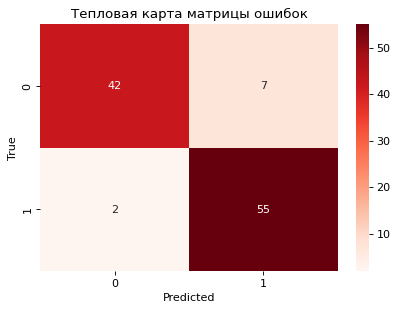

In [23]:
evaluate_model(best_model_forest_tf, tfidf_test, y_test, 'Reds')

#### Модель RandomForestClassifier на данных, векторизованных Doc2Vec

F1-мера: 0.71
AUC-ROC: 0.59


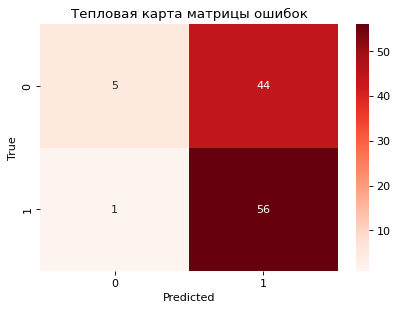

In [24]:
evaluate_model(best_model_forest_vec, split_df_test, y_test, 'Reds')

In [25]:
# функция для подбора параметров при попытке сбалансировать классы
def find_best_model(tfidf_train, y_train, tfidf_test, y_test):
    best_model = None
    best_result = 0
    best_depth = 0
    best_est = 0

    for depth in range(1, 20):
        for est in range(2, 30):
            model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est, class_weight='balanced')
            model.fit(tfidf_train, y_train)
            predicted = model.predict(tfidf_test)
            result = f1_score(y_test, predicted)

            if result > best_result:
                best_model = model
                best_result = result
                best_depth = depth
                best_est = est

    return best_model

In [26]:
# модель на данных, векторизованных TF-IDF
best_model_forest_tf_w = find_best_model(tfidf_train, y_train, tfidf_test, y_test)
# модель на данных, векторизованных Doc2Vec
best_model_forest_vec_w = find_best_model(split_df_train, y_train, split_df_test, y_test)

#### Модель RandomForestClassifier (с балансированными классами) на данных, векторизованных TF-IDF


F1-мера: 0.93
AUC-ROC: 0.96


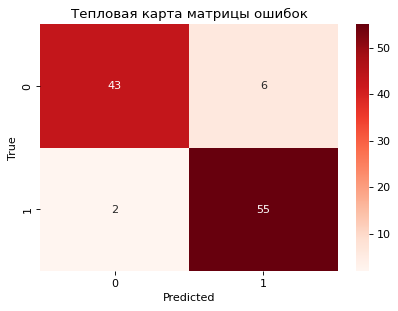

In [27]:
evaluate_model(best_model_forest_tf_w, tfidf_test, y_test, 'Reds')

#### Модель RandomForestClassifier (с балансированными классами) на данных, векторизованных Doc2Vec

F1-мера: 0.70
AUC-ROC: 0.61


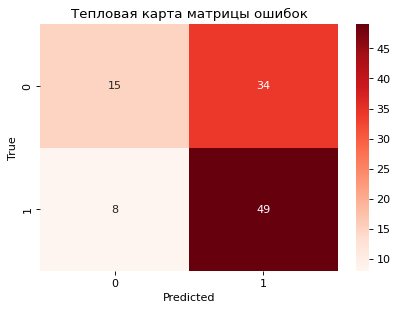

In [28]:
evaluate_model(best_model_forest_vec_w, split_df_test, y_test, 'Reds')

По метрике F1 лучшая модель среди моделей RandomForestClassifier - модель RandomForestClassifier (с балансированными классами) на данных, векторизованных TF-IDF. F1 = 0.93. По метрике AUC-ROC лучшая модель - модель RandomForestClassifier на данных, векторизованных TF-IDF. AUC-ROC = 0.97. Таким образом, мы видим, что модели на данных, векторизованных Doc2Vec, показывают худшие результаты. Если сравнивать модели LogisticRegression и RandomForestClassifier, то модель RandomForestClassifier на данных, векторизованных TF-IDF и сбалансированных, оказывается лучше: F1 = 0.93, AUC-ROC = 0.96.

## Модель CatBoostClassifier

In [36]:
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'depth': [4, 6, 8]
}

In [37]:
model = CatBoostClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

grid_search.fit(tfidf_train, y_train)

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 0.6925145	total: 9.79ms	remaining: 969ms
1:	learn: 0.6918453	total: 19.9ms	remaining: 975ms
2:	learn: 0.6911455	total: 29.6ms	remaining: 958ms
3:	learn: 0.6902572	total: 39.2ms	remaining: 941ms
4:	learn: 0.6895760	total: 50.5ms	remaining: 960ms
5:	learn: 0.6890114	total: 61.1ms	remaining: 957ms
6:	learn: 0.6885235	total: 70.8ms	remaining: 941ms
7:	learn: 0.6878514	total: 80.8ms	remaining: 929ms
8:	learn: 0.6873274	total: 90.8ms	remaining: 919ms
9:	learn: 0.6866143	total: 101ms	remaining: 906ms
10:	learn: 0.6859598	total: 110ms	remaining: 892ms
11:	learn: 0.6853881	total: 122ms	remaining: 892ms
12:	learn: 0.6849391	total: 131ms	remaining: 878ms
13:	learn: 0.6844028	total: 141ms	remaining: 866ms
14:	learn: 0.6838500	total: 151ms	remaining: 855ms
15:	learn: 0.6831542	total: 161ms	remaining: 844ms
16:	learn: 0.6826708	total: 167ms	remaining: 814ms
17:	learn: 0.6821994	total: 177ms	remaining: 807ms
18:	learn: 0.68

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f915cb5fd90>,
             param_grid={'depth': [4, 6, 8], 'iterations': [100, 200, 300],
                         'learning_rate': [0.1, 0.01, 0.001]})

In [38]:
# Получение наилучших параметров и модели
best_params = grid_search.best_params_
best_model_catboost = grid_search.best_estimator_

In [39]:
best_params

{'depth': 6, 'iterations': 300, 'learning_rate': 0.01}

F1-мера: 0.91
AUC-ROC: 0.96


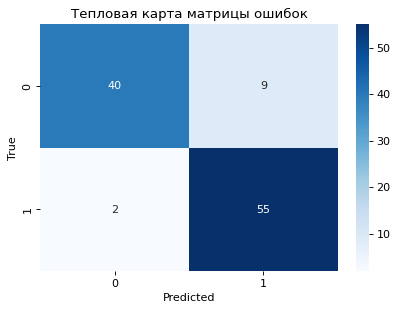

In [40]:
evaluate_model(best_model_catboost, tfidf_test, y_test, 'Blues')

Модель CatBoostClassifier на данных, векторизованных TF-IDF, показывает тоже хорошие результаты: F1 = 0.91 и AUC-ROC = 0.96. Однако лучшей остается модель RandomForestClassifier на данных, векторизованных TF-IDF: F1 = 0.93, AUC-ROC = 0.96.